In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
import time
import cv2
import supervision as sv


In [2]:
#Load the Dataset

CELEBA_DATA_PATH = './'
IMG_PATH = os.path.join(CELEBA_DATA_PATH, 'img_align_celeba')
ATTR_PATH = os.path.join(CELEBA_DATA_PATH,'list_attr_celeba.csv')
PARTITION_PATH = os.path.join(CELEBA_DATA_PATH,'list_eval_partition.csv')
BBOX_PATH = os.path.join(CELEBA_DATA_PATH,'list_bbox_celeba.csv')


def getImagePath(image_id):
    return os.path.join(IMG_PATH,image_id)


In [3]:
attributes_df = pd.read_csv(ATTR_PATH)
partition_df = pd.read_csv(PARTITION_PATH)
bbox_df = pd.read_csv(BBOX_PATH)

gender_age_df = attributes_df[['image_id', 'Male', 'Young']].copy()
gender_age_df.rename(columns={'Male': 'Gender', 'Young': 'Age'}, inplace=True)

gender_age_df['Gender'] = gender_age_df['Gender'].map({1: 'Male', -1: 'Female'})
gender_age_df['Age'] = gender_age_df['Age'].map({1: 'Young', -1: 'Old'})
merged_df = gender_age_df.merge(partition_df, left_on='image_id', right_on='image_id')
merged_df = merged_df.merge(bbox_df, left_on='image_id', right_on='image_id')
merged_df.head()

,image_id,Gender,Age,partition,x_1,y_1,width,height
0,000001.jpg,Female,Young,0,95,71,226,313
1,000002.jpg,Female,Young,0,72,94,221,306
2,000003.jpg,Male,Young,0,216,59,91,126
3,000004.jpg,Female,Young,0,622,257,564,781
4,000005.jpg,Female,Young,0,236,109,120,166


## Bounding boxes provided in CelebA are not good enough
To improve accuracy of segmentation, we want to use bounding boxes to narrow down the search and get a more accurate result

However using the bounding boxes that are labelled by CelebA, we see that the bounding boxes are not too accurate.

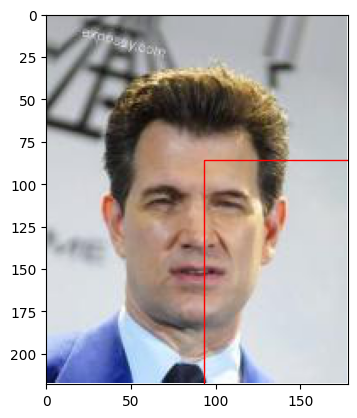

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io

test = merged_df.loc[14]
image = getImagePath(test['image_id'])
xyxy = [test['x_1'], test['y_1'], test['width'], test['height']]

# Replace 'path_to_your_image.jpg' with the actual path to your image file
image_path = getImagePath(test['image_id'])
image = io.imread(image_path)

# Bounding box coordinates and dimensions
bbox = xyxy

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Create a Rectangle patch
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Set the x and y axis limits to match the image size if needed
ax.set_xlim(0, image.shape[1])
ax.set_ylim(image.shape[0], 0)  # Y-axis is inverted for images

# Show the plot with the bounding box
plt.show()


## Tweaking Bounding Box generation and segmentation with YOLOV8 and Mobile SAM

We decided to use yolov8 to generate more accurate bounding boxes, and used mobile SAM to generate masks quickly.  

In [9]:
import cv2
from ultralytics import YOLO, SAM
import supervision as sv
from PIL import Image

CURRENT_DIR = os.getcwd()
test = merged_df.loc[101]
SOURCE_IMAGE_PATH = getImagePath(test['image_id'])
image = cv2.imread(SOURCE_IMAGE_PATH)

model = YOLO('yolov8s.pt')
person_class_index = 0 # ultralytics class dictionary
results= model.predict(image, conf=0.5, classes=[person_class_index])
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]
print(bbox)


image = cv2.cvtColor(cv2.imread(SOURCE_IMAGE_PATH), cv2.COLOR_BGR2RGB)
mobile_sam_model = SAM('mobile_sam.pt')
sam_output = mobile_sam_model.predict(image, bboxes=bbox, iou=0.9 )
for result in sam_output:
    masks = result.masks
mask_object = sam_output[0].masks
mask_tensor = mask_object.data
mask_np = mask_tensor.numpy()


0: 640x544 1 person, 94.8ms
Speed: 1.7ms preprocess, 94.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)



[25.100427627563477, 54.025611877441406, 178.0, 217.46316528320312]


0: 1024x1024 536.1ms
Speed: 7.2ms preprocess, 536.1ms inference, 0.3ms postprocess per image at shape (1, 3, 1024, 1024)


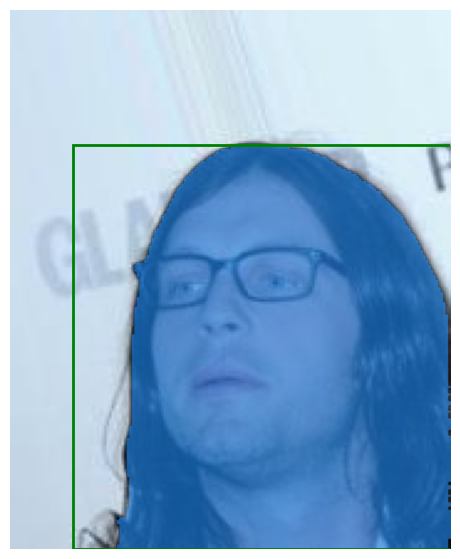

In [11]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    
    
    
import numpy as np
import matplotlib.pyplot as plt

input_box = np.array(bbox)
plt.figure(figsize=(7, 7))
plt.imshow(image)
show_mask(mask_np, plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

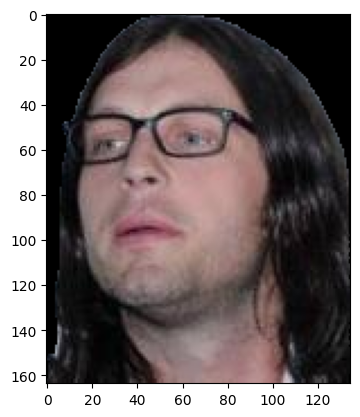

<Figure size 700x700 with 0 Axes>

In [12]:
mask_2d = mask_np.squeeze(axis=0)
# Ensure the mask is the same size as the image
masked_image = np.zeros_like(image)
for c in range(image.shape[2]):  # Assuming image has 3 channels
    masked_image[..., c] = image[..., c] * mask_2d

y_indices, x_indices = np.where(mask_2d)
x_min, x_max = x_indices.min(), x_indices.max()
y_min, y_max = y_indices.min(), y_indices.max()
cropped_image = masked_image[y_min:y_max+1, x_min:x_max+1]

plt.imshow(cropped_image)
plt.figure(figsize=(7, 7))
plt.show()

## Resize to NN input dims & Normalise pixel values

In [13]:
resize_dims = (224, 224)  # Example for a network expecting 224x224x3 input
resized_image = cv2.resize(cropped_image, resize_dims)
normalized_image = resized_image / 255.0  # Scale pixel values to [0, 1]
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB) #convert to rgb from cv2 bgr

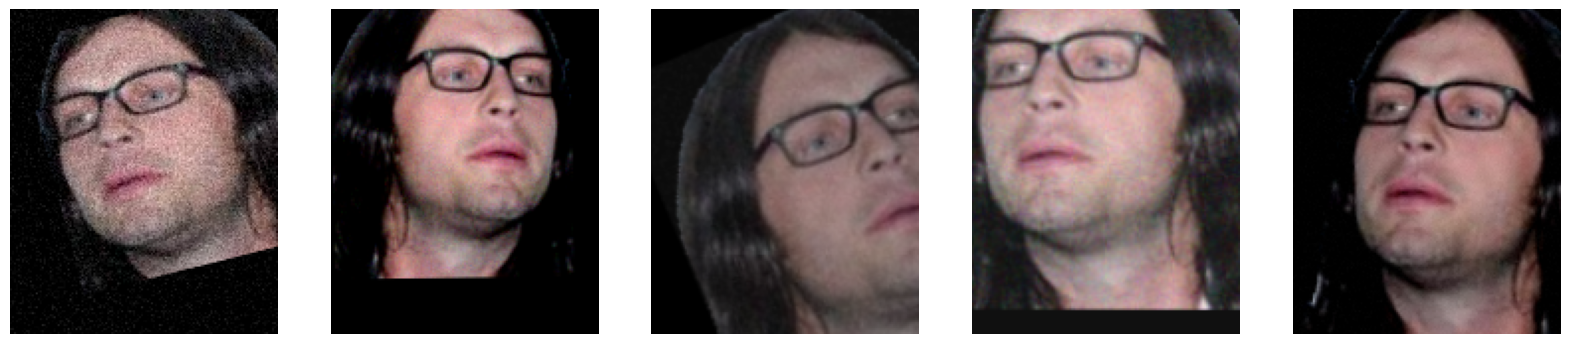

In [14]:
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Crop(percent=(0, 0.1)),  # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add Gaussian noise.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)  # apply augmenters in random order

augmented_images = [seq(image=cropped_image) for _ in range(5)]

# Display the augmented images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, img in zip(axes, augmented_images):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert back to RGB for displaying
    ax.axis('off')
plt.show()

# Scripts for preprocessing

Export all the previous functions into data_preprocessing.py, and call the script to save our preprocessed images

In [ ]:
from ultralytics.utils.torch_utils import select_device
from data_preprocessing import process_partition, load_data
from ultralytics import YOLO, SAM
import imgaug.augmenters as iaa
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

train_df, val_df, test_df = load_data()

# choose 50k, extra 1k for if the data processing skips the current image due to poor box or segmentation generation
train_df = train_df.head(51000)

# start from where i last stopped
# train_df = train_df.iloc[65090 - 1:]

# change to gpu or empty string to auto-select first avail
selected_device = select_device(device='gpu', batch=32, newline=False, verbose=True) 
print(f"Using device: {selected_device}")

# Initialize models
yolo_model = YOLO('yolov8s.pt')
sam_model = SAM('mobile_sam.pt')

augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flips
    iaa.Crop(percent=(0, 0.1)),  # Random crops
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
    iaa.ContrastNormalization((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)

resize_dims = (224, 224)
train_processed = process_partition(train_df, yolo_model, sam_model, resize_dims, augmenter)